In [1]:

# 安装依赖包
!pip install d2l 
!pip install py7zr

# 导入库
import os
import shutil
import math
import collections
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 85.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 77.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 86.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 50.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.

In [2]:
!cp /kaggle/input/cifar-10/trainLabels.csv /kaggle/working/
data_dir = '/kaggle/working/'
#@save
def read_csv_labels(fname):

    with open(fname, 'r') as f:
    # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练样本 : 50000
# 类别 : 10


In [3]:
file_Path  = '/kaggle/input/cifar-10/train.7z'
output_dir = '/kaggle/working/'

with py7zr.SevenZipFile(file_Path , mode='r') as z:
    z.extractall(output_dir)

In [4]:
file_Path  = '/kaggle/input/cifar-10/test.7z'
output_dir = '/kaggle/working/'

with py7zr.SevenZipFile(file_Path , mode='r') as z:
    z.extractall(output_dir)

In [5]:
def copyfile(filename, target_dir):

    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)
#@save

def read_csv_labels(fname):

    with open(fname, 'r') as f:
    # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))


def reorg_train_valid(data_dir, labels, valid_ratio):

# 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
# 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test','train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test','valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test','train', label))
    return n_valid_per_label

#@save
def reorg_test(data_dir):

    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),os.path.join(data_dir, 'train_valid_test', 'test','unknown'))
        
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir,'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

batch_size = 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [6]:

transform_train = torchvision.transforms.Compose(
[
    torchvision.transforms.Resize(128),  # 将图像的短边调整到128像素
    torchvision.transforms.RandomResizedCrop(128, scale=(0.64, 1.0)),  # 随机裁剪并调整尺寸
    torchvision.transforms.RandomHorizontalFlip(0.5),  # 保持水平翻转
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 轻微颜色扰动
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.489, 0.455, 0.404], std=[0.220, 0.221, 0.223]),  # 每个通道进行标准化。
])

transform_test = torchvision.transforms.Compose([ torchvision.transforms.Resize(128),  # 保持相同的尺寸调整
    torchvision.transforms.CenterCrop(128),  # 中心裁剪，保持一致性
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.489, 0.455, 0.404], std=[0.220, 0.221, 0.223]),]) # 保持相同的标准化)

train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder), transform=transform_train) for
    folder in ['train', 'train_valid']]

train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
os.path.join(data_dir, 'train_valid_test', folder),
transform=transform_train) for folder in ['train', 'train_valid']]
valid_ds, test_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder),transform=transform_test) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, drop_last=True)for dataset in (train_ds, train_valid_ds)]
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,drop_last=False)

In [7]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net


loss = nn.CrossEntropyLoss(reduction="none")


def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    # 创建 DataParallel 实例
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)

    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()

    measures = f'train loss {metric[0] / metric[2]:.3f}, 'f'train acc {metric[1] / metric[2]:.3f}'
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'f' examples/sec on {str(devices)}')

train loss 0.214, train acc 0.927, valid acc 0.880
174.3 examples/sec on [device(type='cuda', index=0)]


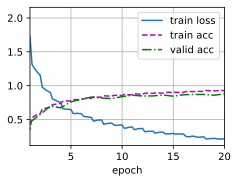

In [8]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
lr_decay)

train loss 0.194, train acc 0.933
174.3 examples/sec on [device(type='cuda', index=0)]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 191.12 MiB is free. Process 2653 has 15.70 GiB memory in use. Of the allocated memory 14.90 GiB is allocated by PyTorch, and 498.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

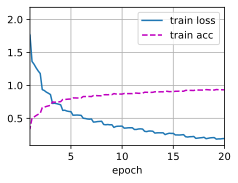

In [9]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
lr_decay)
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)

In [17]:
# 确保保存路径的格式是正确的
model_save_path = r'C:\Users\曹宇\Desktop\大作业\人工智能\my_model.pth'

try:
    # 保存模型
    torch.save(net.state_dict(), model_save_path)
    print(f'Model saved to {model_save_path}')
except Exception as e:
    print(f'Error saving model: {e}')

# 检查文件是否存在
if os.path.exists(model_save_path):
    print("Model file successfully saved.")
else:
    print("Failed to save the model file.")

Model saved to C:\Users\曹宇\Desktop\大作业\人工智能\my_model.pth
Model file successfully saved.
